<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/EECE5644_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install ipympl

# **Importing necessary libraries**

In [ ]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

import matplotlib.pyplot as plt # For general plotting
import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal

In [ ]:
def gmm_data(N, prob_distribution):
    # Determine dimensionality from mixture PDF parameters
    n = prob_distribution['mu'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)

    # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(prob_distribution['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(prob_distribution['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)
        labels[indices] = l * np.ones(Nl) - 1
        # If dealing with a univariate Gaussian, use norm.rvs to sample RVs and not the multivariate version
        if n == 1:
            X[indices, 0] =  norm.rvs(prob_distribution['mu'][l-1], prob_distribution['Cov_matrix'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(prob_distribution['mu'][l-1], prob_distribution['Cov_matrix'][l-1], Nl)

    return X, labels

In [ ]:
from sys import float_info

def ROC_data(discriminant_score, labels):
    # Count the positive and negative samples
    num_neg, num_pos = np.sum(labels == 0), np.sum(labels == 1)

    # Sort scores for thresholding
    sorted_scores = np.sort(discriminant_score)

    # Define gamma thresholds: adding epsilon to include edge cases
    gammas = np.concatenate(([sorted_scores[0] - float_info.epsilon], sorted_scores,
                             [sorted_scores[-1] + float_info.epsilon]))

    # Initialize lists to hold the True Positive Rates and False Positive Rates
    TPR = []
    FPR = []

    # Compute TPR and FPR for each threshold
    for gamma in gammas:
        predictions = discriminant_score >= gamma
        TP = np.sum((predictions == 1) & (labels == 1))
        FP = np.sum((predictions == 1) & (labels == 0))

        TPR.append(TP / num_pos if num_pos else 0)
        FPR.append(FP / num_neg if num_neg else 0)

    # Pack results into a dictionary
    roc = {'FPR': np.array(FPR), 'TPR': np.array(TPR)}

    return roc, gammas

def compute_classification_metrics(predictions, actual_labels):
    # Ensure actual_labels are integers for np.bincount
    actual_labels = actual_labels.astype(int)

    # Count occurrences of 0s and 1s in actual_labels
    counts = np.bincount(actual_labels)

    # Make sure there are counts for both 0 and 1 labels
    num_neg = counts[0] if len(counts) > 0 else 0
    num_pos = counts[1] if len(counts) > 1 else 0

    tn = np.sum((predictions == 0) & (actual_labels == 0))
    fp = np.sum((predictions == 1) & (actual_labels == 0))
    fn = np.sum((predictions == 0) & (actual_labels == 1))
    tp = np.sum((predictions == 1) & (actual_labels == 1))

    metrics = {
        'TNR': tn / num_neg if num_neg != 0 else 0,  # True Negative Rate
        'FPR': fp / num_neg if num_neg != 0 else 0,  # False Positive Rate
        'FNR': fn / num_pos if num_pos != 0 else 0,  # False Negative Rate
        'TPR': tp / num_pos if num_pos != 0 else 0   # True Positive Rate
    }

    return metrics

# **Generating dataset**

In [ ]:
# Generate dataset from two different 3D Gaussian distributions/categories
N = 10000

gmm_distribution = {}

# Class priors
gmm_distribution['priors'] = np.array([0.7, 0.3])
num_classes = len(gmm_distribution['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_distribution['mu'] = np.array([
        [-1, 1, -1, 1],  # Mean for class 0
        [1, 1, 1, 1]     # Mean for class 1
    ])  # Gaussian distributions means
gmm_distribution['Cov_matrix'] = np.array([
        [[2, -0.5, 0.3, 0], [-0.5, 1, -0.5, 0], [0.3, -0.5, 1, 0], [0, 0, 0, 2]],  # Covariance for class 0
        [[1, 0.3, -0.2, 0], [0.3, 2, 0.3, 0], [-0.2, 0.3, 1, 0], [0, 0, 0, 3]]      # Covariance for class 1
    ])  # Gaussian distributions covariance matrices

X, labels = gmm_data(N, gmm_distribution)

n = X.shape[1]
L = np.array(range(num_classes))

# Count up the number of samples per class
sample_dist = np.array([sum(labels == l) for l in L])
print(sample_dist)


[6996 3004]


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# **Part A : ERM based classification using the knowledge of True ddata pdf**

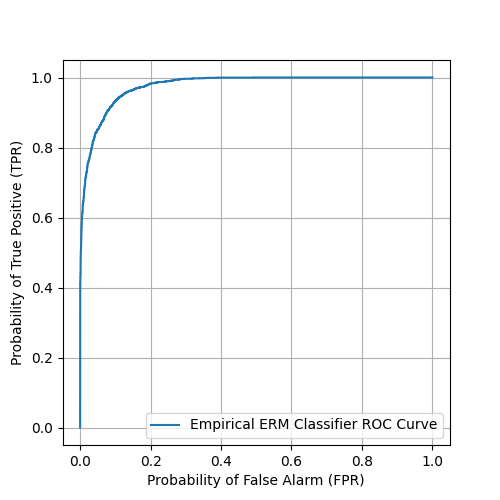

In [ ]:
# Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
def calculate_class_conditional_likelihoods(X, gmm_params, num_classes):
    return np.array([
        multivariate_normal.pdf(X, mean=gmm_params['mu'][i], cov=gmm_params['Cov_matrix'][i])
        for i in range(num_classes)
    ])

class_conditional_likelihoods = calculate_class_conditional_likelihoods(X, gmm_distribution, num_classes)

# Class conditional log likelihoods equate to log gamma at the decision boundary
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Estimate ROC
roc_erm, gammas_empirical = ROC_data(discriminant_score_erm, labels)  # labels must be defined

# Create and show the plot
fig_roc, ax_roc = plt.subplots(figsize=(5, 5))
ax_roc.plot(roc_erm['FPR'], roc_erm['TPR'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel("Probability of False Alarm (FPR)")
ax_roc.set_ylabel("Probability of True Positive (TPR)")
ax_roc.grid(True)
plt.legend()
plt.show()

Min Empirical Pr(error) for ERM = 0.078
Min Empirical Gamma = 2.987
Min Theoretical Pr(error) for ERM = 0.081
Min Theoretical Gamma = 2.333


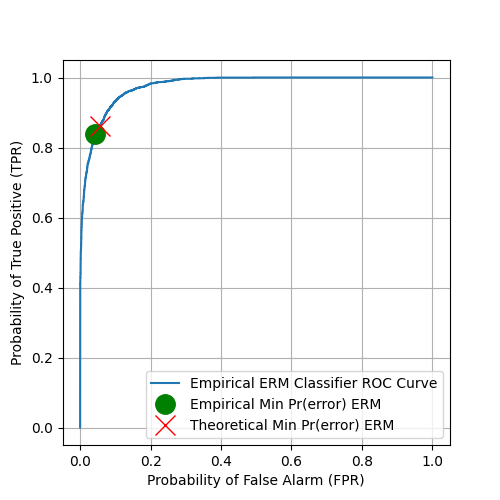

In [ ]:
prob_error_empirical = np.array([roc_erm['FPR'], 1 - roc_erm['TPR']]).T @ (sample_dist / N)

# Identify the minimum probability of error and the corresponding index
min_prob_error_empirical = np.min(prob_error_empirical)
min_index_empirical = np.argmin(prob_error_empirical)

# Calculate the theoretical gamma as the log-ratio of class priors (assuming 0-1 loss)
# This is for the Maximum A Posteriori (MAP) classification rule
gamma_map = np.log(gmm_distribution['priors'][0] / gmm_distribution['priors'][1])
decisions_map = discriminant_score_erm >= gamma_map

# Compute classification metrics for MAP decisions
class_metrics_map = compute_classification_metrics(decisions_map, labels)
# Calculate theoretical minimum probability of error using FPR and FNR
min_prob_error_map = (class_metrics_map['FPR'] * gmm_distribution['priors'][0] +
                      class_metrics_map['FNR'] * gmm_distribution['priors'][1])

# Plotting the points indicating minimum probability of error
ax_roc.plot(roc_erm['FPR'][min_index_empirical], roc_erm['TPR'][min_index_empirical], 'go',
            label="Empirical Min Pr(error) ERM", markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx',
            label="Theoretical Min Pr(error) ERM", markersize=14)
plt.legend()

# Output the results
print(f"Min Empirical Pr(error) for ERM = {min_prob_error_empirical:.3f}")
print(f"Min Empirical Gamma = {np.exp(gammas_empirical[min_index_empirical]):.3f}")

print(f"Min Theoretical Pr(error) for ERM = {min_prob_error_map:.3f}")
print(f"Min Theoretical Gamma = {np.exp(gamma_map):.3f}")

# Display the updated plot
plt.show()

# **Part B: Application of Naive Bayes classifier**

Min Naive Pr(error) for ERM = 0.093, Gamma = 4.562
Min Empirical Pr(error) for ERM = 0.078, Gamma = 2.987
Min Theoretical Pr(error) for ERM = 0.081, Gamma = 2.333


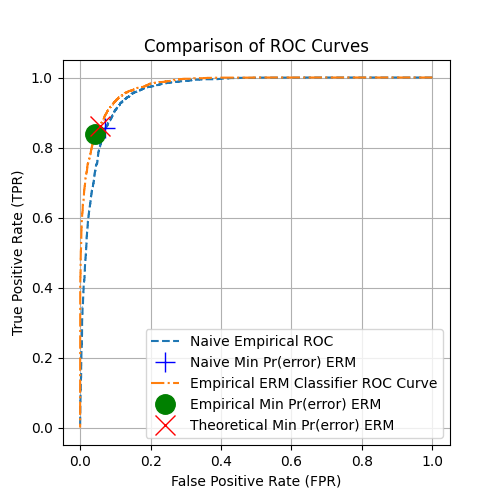

In [ ]:
# Define theoretical gamma based on log-ratio of class priors if using a Bayesian approach
naive_class_conditional_likelihoods = np.array([
    multivariate_normal.pdf(X, mean=gmm_distribution['mu'][l], cov=np.eye(X.shape[1])) for l in range(len(gmm_distribution['mu']))
])

# Compute the class conditional log likelihoods to define the discriminant score
discriminant_score_naive = np.log(naive_class_conditional_likelihoods[1]) - np.log(naive_class_conditional_likelihoods[0])

# Calculate ROC for Naive Bayes and Empirical ERM
roc_naive, gammas_naive = ROC_data(discriminant_score_naive, labels)
roc_erm, gammas_erm = ROC_data(discriminant_score_erm, labels)  # This needs to be computed if not already

# Calculate probability of error for Naive Bayes
prob_error_naive = np.array([roc_naive['FPR'], 1 - roc_naive['TPR']]).T @ (sample_dist / np.sum(sample_dist))
min_prob_error_naive = np.min(prob_error_naive)
min_ind_naive = np.argmin(prob_error_naive)

# Output the probabilities of error and gamma values
print(f"Min Naive Pr(error) for ERM = {min_prob_error_naive:.3f}, Gamma = {np.exp(gammas_naive[min_ind_naive]):.3f}")
print(f"Min Empirical Pr(error) for ERM = {min_prob_error_empirical:.3f}, Gamma = {np.exp(gammas_empirical[min_index_empirical]):.3f}")
print(f"Min Theoretical Pr(error) for ERM = {min_prob_error_map:.3f}, Gamma = {np.exp(gamma_map):.3f}")

# Plotting all components together
fig_roc, ax_roc = plt.subplots(figsize=(5, 5))
# Plot Naive Bayes ROC curve
ax_roc.plot(roc_naive['FPR'], roc_naive['TPR'], linestyle='--', label="Naive Empirical ROC")
ax_roc.plot(roc_naive['FPR'][min_ind_naive], roc_naive['TPR'][min_ind_naive], 'b+', markersize=14, label="Naive Min Pr(error) ERM")
# Plotting the points indicating minimum probability of error
ax_roc.plot(roc_erm['FPR'], roc_erm['TPR'], linestyle='-.', label="Empirical ERM Classifier ROC Curve")
ax_roc.plot(roc_erm['FPR'][min_index_empirical], roc_erm['TPR'][min_index_empirical], 'go',
            label="Empirical Min Pr(error) ERM", markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx',
            label="Theoretical Min Pr(error) ERM", markersize=14)

ax_roc.set_xlabel("False Positive Rate (FPR)")
ax_roc.set_ylabel("True Positive Rate (TPR)")
ax_roc.set_title("Comparison of ROC Curves")
ax_roc.grid(True)
ax_roc.legend()

plt.show()